# Data Processing

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

import gym
from gym_anytrading.envs import StocksEnv
from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import PPO

In [2]:
df = pd.read_csv("spy.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2/11/2022,449.41,451.61,438.94,440.46,"153,214,594"
1,2/10/2022,451.34,457.71,447.20,449.32,"140,103,703"
2,2/9/2022,455.22,457.88,455.01,457.54,"92,589,930"
3,2/8/2022,446.73,451.92,445.22,450.94,"81,012,039"
4,2/7/2022,449.51,450.99,445.85,447.26,"84,472,867"


In [4]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", ascending=True, inplace=True)
df.set_index("Date", inplace=True)
df["Volume"] = df["Volume"].apply(lambda x: float(x.replace(",", "")))
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-02-11,336.16,337.02,334.68,335.26,54864527.0
2020-02-12,336.83,337.65,336.43,337.42,43992660.0
2020-02-13,335.86,338.12,335.56,337.06,54501922.0
2020-02-14,337.51,337.73,336.20,337.60,64582207.0
2020-02-18,336.51,337.67,335.21,336.73,57342527.0


In [6]:
df["SMA"] = TA.SMA(df, 12)
df["RSI"] = TA.RSI(df)
df["OBV"] = TA.OBV(df)
df.fillna(0, inplace=True)
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-02-11,336.16,337.02,334.68,335.26,54864527.0,0.0,0.000000,0.0
2020-02-12,336.83,337.65,336.43,337.42,43992660.0,0.0,100.000000,43992660.0
2020-02-13,335.86,338.12,335.56,337.06,54501922.0,0.0,84.782609,-10509262.0
2020-02-14,337.51,337.73,336.20,337.60,64582207.0,0.0,87.785235,54072945.0
2020-02-18,336.51,337.67,335.21,336.73,57342527.0,0.0,65.396646,-3269582.0


In [7]:
window_frame = 30

train_frame = (window_frame,int(len(df)*0.7))
test_frame = (int(len(df)*0.7),int(len(df)))
train_steps = 75000

# Random Actions

info {'total_reward': 86.91000000000011, 'total_profit': 0.38589190496667086, 'position': 1}


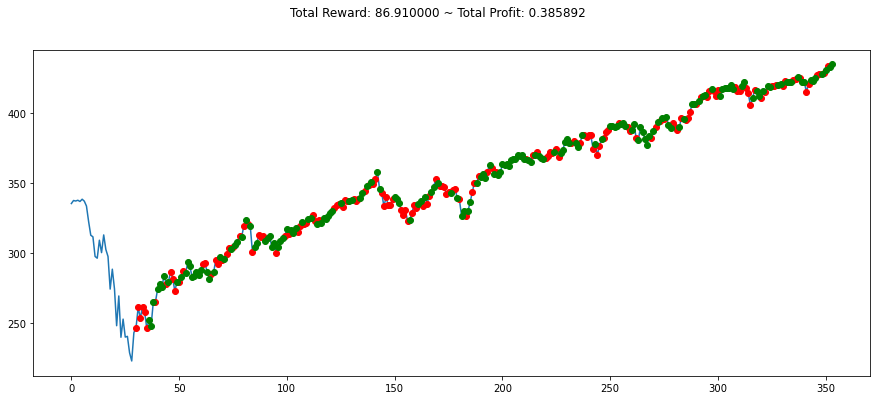

In [8]:
# Train Set Evaluation
env = gym.make('stocks-v0', df=df, frame_bound=train_frame, window_size=window_frame)
states = env.observation_space.shape
actions = env.action_space.n

state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': -24.650000000000148, 'total_profit': 0.5267273156429283, 'position': 1}


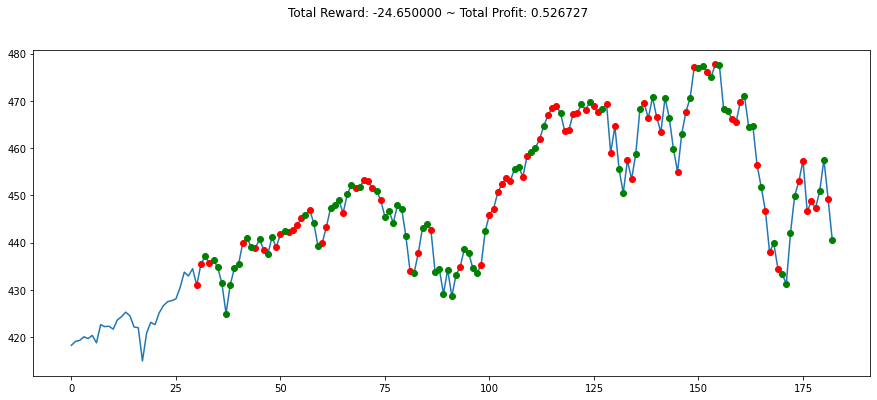

In [9]:
# Test Set Evaluation
env = gym.make('stocks-v0', df=df, frame_bound=test_frame, window_size=window_frame)
states = env.observation_space.shape
actions = env.action_space.n

state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Default Environment

In [10]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=train_frame, window_size=window_frame)
env = DummyVecEnv([env_maker])

In [11]:
model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=train_steps)

info {'total_reward': 96.58999999999978, 'total_profit': 0.36494774048835193, 'position': 1}


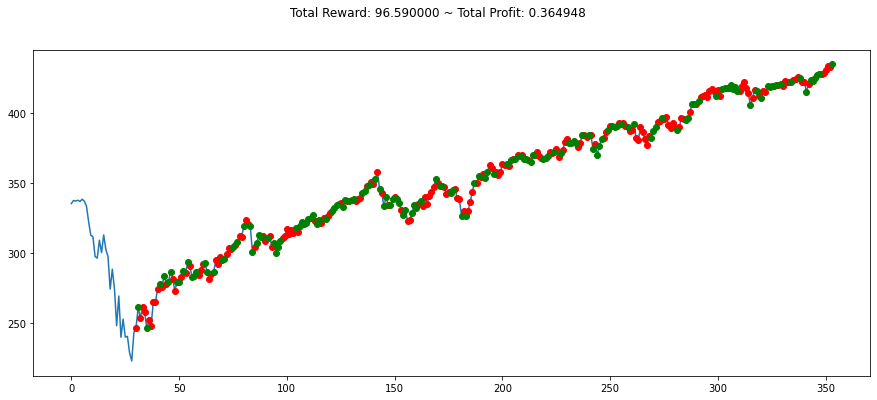

In [12]:
# Train Set Evaluation
env = gym.make('stocks-v0', df=df, frame_bound=train_frame, window_size=window_frame)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': -13.780000000000086, 'total_profit': 0.5555372289043294, 'position': 1}


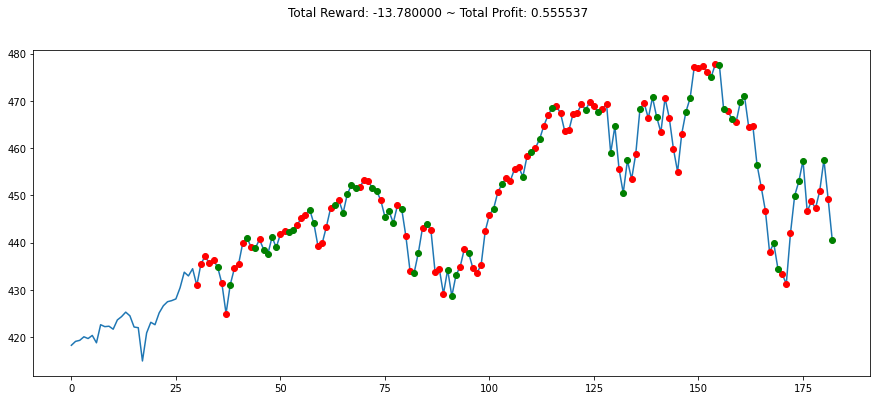

In [13]:
# Test Set Evaluation
env = gym.make('stocks-v0', df=df, frame_bound=test_frame, window_size=window_frame)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Building the Custom Environment

In [14]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, "Low"].to_numpy()[start:end]
#     signal_features = env.df.loc[:, ["Open", "High", "Low", "Close", "Volume", "SMA", "RSI", "OBV"]].to_numpy()[start:end] # Can add more features
    signal_features = env.df.loc[:, ["Low", "Volume", "SMA", "RSI", "OBV"]].to_numpy()[start:end] # Can add more features
    return prices, signal_features

In [15]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

In [16]:
env_maker = lambda: MyCustomEnv(df=df, frame_bound=train_frame, window_size=window_frame)
env = DummyVecEnv([env_maker])

In [17]:
model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=train_steps)

info {'total_reward': 236.07000000000005, 'total_profit': 0.6866828667838121, 'position': 0}


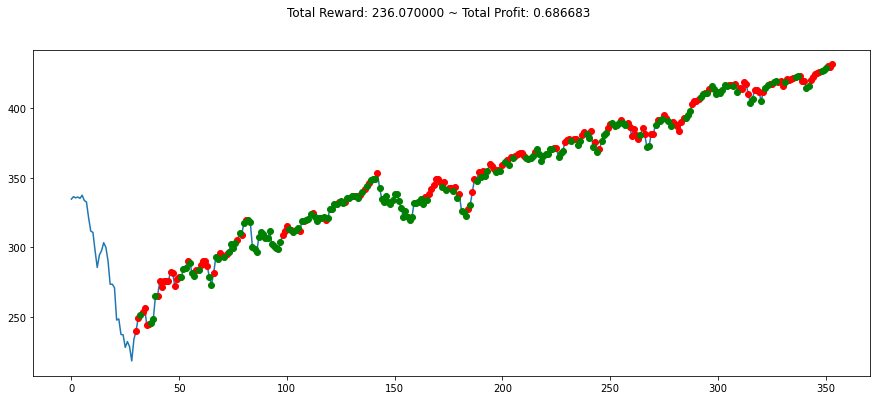

In [18]:
# Train Set Evaluation
env = MyCustomEnv(df=df, frame_bound=train_frame, window_size=window_frame)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': -19.019999999999982, 'total_profit': 0.69703186339367, 'position': 0}


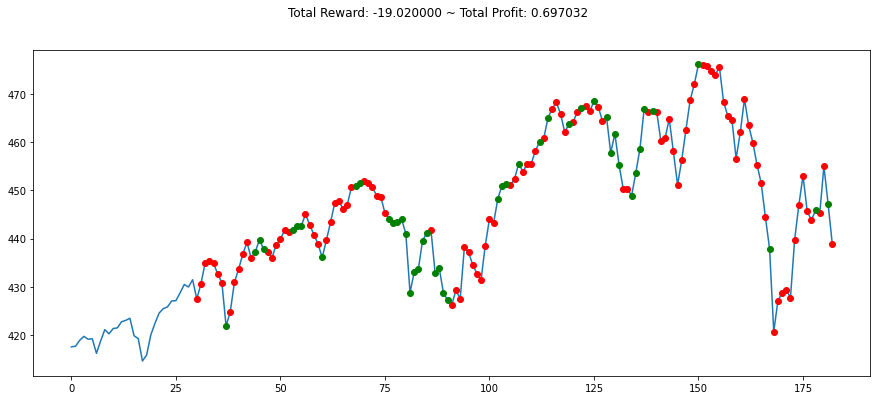

In [22]:
# Test Set Evaluation
env = MyCustomEnv(df=df, frame_bound=test_frame, window_size=window_frame)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# Summary
